# Delay Calculation Validation Experiments

- Note that you'll have to be on an updated branch ... (to be pushed pending exising PRs)
     - There is way to much going on in the current PRs, don't want to add complexity just yet

In [1]:
import os, os.path as op
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from RAiDER.llreader import BoundingBox
from RAiDER.losreader import Raytracing, getTopOfAtmosphere
from RAiDER.delay import tropo_delay
from RAiDER.utilFcns import lla2ecef, ecef2lla
from RAiDER.models.gmao import GMAO
from RAiDER.models.weatherModel import make_weather_model_filename
import yaml

plt.switch_backend('MacOSX')
%matplotlib inline
%pdb off

# change this to the directory with the notebook
wd = op.join(op.expanduser('~'), 'Software_InSAR','RAiDER-docs_git','notebooks', 'Synthetic_Test')
WM = 'GMAO'

yaml_GUNW = f'{wd}/GUNW_Base.yaml' # manually created

os.chdir(wd)
print ('Working directory (WD):', wd)

Automatic pdb calling has been turned OFF
Working directory (WD): /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test


## Tools

In [2]:
def new_yaml_group(example_yaml, dct_group, dst='tmp.yaml'):
    """ Write a temporary yaml file with the new 'value' for 'key', preserving parms in example_yaml"""
    with open(example_yaml, 'r') as f:
        try:
            params = yaml.safe_load(f)
        except yaml.YAMLError as exc:
            print(exc)
            raise ValueError(f'Something is wrong with the yaml file {example_yaml}')

    params = {**params, **dct_group}
    dst = op.join(os.path.dirname(example_yaml), dst)
    
    with open(dst, 'w') as fh:
        yaml.dump(params, fh, default_flow_style=False)
    
    print ('Wrote new cfg file:', dst)
    return dst


def update_GMAO(gmao_obj, wm_file):
    wet = gmao_obj.getWetRefractivity()
    dry = gmao_obj.getHydroRefractivity()
    wet_total = gmao_obj._wet_ztd
    dry_total = gmao_obj._hydrostatic_ztd
    with xr.open_dataset(wm_file) as ds:
        ds['wet']   = ('z y x'.split(), wet.transpose(2, 0, 1))
        ds['hydro'] = ('z y x'.split(), dry.transpose(2, 0, 1))
        
       
        ds['wet_total']   = ('z y x'.split(), wet_total.transpose(2, 0, 1))
        ds['hydro_total'] = ('z y x'.split(), dry_total.transpose(2, 0, 1))
        
    dst = f'{op.splitext(wm_file)[0]}_SYNTH.nc'.replace('_REAL', '')
    os.remove(dst) if op.exists(dst) else ''
    ds.to_netcdf(dst)
    print ('Wrote synthetic weather model file to:', dst)
    return dst

In [3]:
class GMAOsynth(GMAO):
    def __init__(self, SNWE, k1=0, k2=0, k3=0):
        super().__init__()
        
        self._setup_grid(SNWE)
        
        self._k1 = k1 # 0.776  # [K/Pa]
        self._k2 = k2 # 0.233  # [K/Pa]
        self._k3 = k3 # 3.75e3  # [K^2/Pa]
        self._p  = np.ones(self.shp) 
        self._t  = self._p
        self._e  = self._p 
        self._get_wet_refractivity()
        self._get_hydro_refractivity()
        self._getZTD() # make the wet/dry variables
        
              
    # unneeded; just to show eqs 
    def _get_wet_refractivity(self):
        '''
        Calculate the wet delay from pressure, temperature, and e
        '''
        self._wet_refractivity = self._k2 * self._e / self._t + self._k3 * self._e / self._t**2
        return self._wet_refractivity
    
    
    def _get_hydro_refractivity(self):
        '''
        Calculate the hydrostatic delay from pressure and temperature
        '''
        self._hydrostatic_refractivity = self._k1 * self._p / self._t
        return self._hydrostatic_refractivity

    
    def _setup_grid(self, SNWE):
        """ Custom; setup the xs and ys (from _fetch)"""
        self.set_latlon_bounds(SNWE)
        lat_min_ind = int((self._ll_bounds[0] - (-90.0)) / self._lat_res)
        lat_max_ind = int((self._ll_bounds[1] - (-90.0)) / self._lat_res)
        lon_min_ind = int((self._ll_bounds[2] - (-180.0)) / self._lon_res)
        lon_max_ind = int((self._ll_bounds[3] - (-180.0)) / self._lon_res)
        
        lats = np.arange(
            (-90 + lat_min_ind * self._lat_res),
            (-90 + (lat_max_ind + 1) * self._lat_res),
            self._lat_res
        )
        lons = np.arange(
            (-180 + lon_min_ind * self._lon_res),
            (-180 + (lon_max_ind + 1) * self._lon_res),
            self._lon_res
        )
        self._xs = lons
        self._ys = lats
        self._zs = self._zlevels # model levels
        self.shp = (self._ys.size, self._xs.size, self._zs.size)

        return

In [30]:
def build_ray_const(target_xyz:list, model_zs, los, constant):
    """ This builds rays only; no impact of delays 
    
    Target xyz is a list of lists (xpts, ypts, hgt_levels)
    Model_zs are all the model levels over which ray is calculated
    los in los object (has the orbit info)
    constant is the value to scale the rays by
    """
    print ('Using constant:', const)

    # Create a regular 2D grid
    xx, yy = np.meshgrid(target_xyz[0], target_xyz[1])
    hgt_lvls = target_xyz[2]
    outputArrs = np.zeros((hgt_lvls.size, target_xyz[1].size, target_xyz[0].size))
    # iterate over height levels
    for hh, ht in enumerate(hgt_lvls):
        
        outSubs = outputArrs[hh, ...] # a 2d array where output is stored and added to (at one heihgt level)
        
        llh = [xx, yy, np.full(yy.shape, ht)]

        xyz = np.stack(lla2ecef(llh[1], llh[0], np.full(yy.shape, ht)), axis=-1)
        LOS = los.getLookVectors(ht, llh, xyz, yy)
            
        cos_factor = None
        
        # iterate over all model levels
        nn=0
        for zz in range(model_zs.size-1):
            low_ht = model_zs[zz]
            high_ht = model_zs[zz + 1]
            
            if (high_ht <= ht) or (low_ht >= 50000):
                continue
                
            # If high_ht > max_tropo_height - integral only up to max tropo
            if high_ht > 50000:
                high_ht = 50000
                
            # If low_ht < height of point - integral only up to height of point
            if low_ht < ht:
                low_ht = ht
                
            # Continue only if needed - 1m troposphere does nothing
            if np.abs(high_ht - low_ht) < 1.0:
                continue

 
            low_xyz = getTopOfAtmosphere(xyz, LOS, low_ht, factor=cos_factor)
            high_xyz = getTopOfAtmosphere(xyz, LOS, high_ht, factor=cos_factor)
            ray_length = np.linalg.norm(high_xyz - low_xyz, axis=-1)
            nParts = int(np.ceil(ray_length.max() / 1000)) + 1

            if cos_factor is None:
                cos_factor = (high_ht - low_ht) / ray_length

            # fractions of ray
            fracs = np.linspace(0., 1., num=nParts)

            # Integrate over the ray
            for findex, ff in enumerate(fracs):
                # Trapezoidal integration with scaling
                wt   = 0.5 if findex in [0, fracs.size-1] else 1.0
                wt  *= ray_length  *1e-6 / (nParts - 1.0)
                outSubs += wt * constant
                nn+1 # counter for stopping

        print (f'Mean delay over height level {ht}: {outSubs.mean():.5f}')
#         break
        
    return outputArrs

## Get/Set defaults

In [4]:
## setup the study area
SNWE = 33, 34, -118.25, -117.25 # 32.979829, 34.944592, -119.272279, -116.251959
dt   = datetime(2020, 1, 30, 13, 52, 45)
dts  = dt.strftime('%Y_%m_%d_T%H_%M_%S')

aoi = BoundingBox(SNWE)
aoi.add_buffer(buffer = 1.5 * 0.3125) # model.getLLRes(); gmao)


orbit     = f'{wd}/S1B_OPER_AUX_POEORB_OPOD_20210317T025713_V20200129T225942_20200131T005942.EOF'
los       = Raytracing(orbit, time=dt)
wm_bounds = aoi.calc_buffer_ray(los.getSensorDirection(), lookDir=los.getLookDirection())

## setup the weather model stuff
Obj  = GMAOsynth(wm_bounds)

path_wm = os.path.join(wd, 'weather_files', make_weather_model_filename(WM, dt, Obj._ll_bounds))

grid_spacing = 0.5
cube_spacing = np.round(grid_spacing/1e-5).astype(np.float32)

hgt_lvls     = np.arange(-500, 1500, 500)

targ_xyz = [Obj._xs, Obj._ys, hgt_lvls] # for the ray

# Test One

Test the hydrostatic calculation
- k1 = a number; 
- P=T; 
- k2=k3=0; 

## Scenario 1a

- no lateral variation.
- integral = k1*ray-length. 



In [6]:
!rm {wd}/weather_files/{WM}*

rm: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/weather_files/GMAO*: No such file or directory


In [5]:
print ('S/N/W/E:', *SNWE)
print ('Grid Spacing:', cube_spacing, 'm')

S/N/W/E: 33 34 -118.25 -117.25
Grid Spacing: 50000.0 m


In [9]:
## run it through with the real weather model file

# remove the weather model file for a clean run
path_wm_real  = f'{op.splitext(path_wm)[0]}_REAL.nc'

# use existing if possible
if op.exists(path_wm_real):
    os.remove(path_wm)
    os.symlink(path_wm_real, path_wm)
else:
    try:
        os.remove(f'{wd}/weather_files/{WM}_{dts}.nc')
    except:
        pass

grp = {
       'aoi_group': {'bounding_box': list(SNWE)},
        'height_group': {
                         'height_levels': hgt_lvls.tolist(),
                        },
        'date_group': {'date_list': datetime.strftime(dt, '%Y%m%d')},
        'cube_spacing_in_m': str(cube_spacing),
        'los_group': {'ray_trace': True, 'orbit_file': orbit},
        'weather_model': WM
      }

cfg = new_yaml_group(yaml_GUNW, grp)
!raider.py {cfg}

if not op.exists(path_wm_real):
    os.rename(path_wm, path_wm_real)

Wrote new cfg file: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/tmp.yaml
Invalid extension GTiff for cube. Defaulting to .nc
Starting to run the weather model calculation
Date: 20200130
Beginning weather model pre-processing
Extent of the weather model is (xmin, ymin, xmax, ymax):-119.38, 32.00, -115.31, 34.75
Extent of the input is (xmin, ymin, xmax, ymax): -118.72, 32.53, -116.22, 34.47
Output SNWE: [32.5, 34.5, -119.0, -116.5]
Output cube spacing: 0.5
Processing slice 1 / 4: -500.0

Mean delay over height level -500.0: 3.12396
Processing slice 2 / 4: 0.0

Mean delay over height level 0.0: 2.95872
Processing slice 3 / 4: 500.0

Mean delay over height level 500.0: 2.79494
Processing slice 4 / 4: 1000.0

Mean delay over height level 1000.0: 2.63673

Successfully wrote delay cube to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/GMAO_tropo_20200130T135245_ray.nc



In [14]:
## run it again with the synthetic model
const = 7.0
Obj   = GMAOsynth(wm_bounds, k1=const, k2=0, k3=0)
path_wm_synth = update_GMAO(Obj, path_wm_real)

os.remove(path_wm) if op.exists(path_wm) or op.islink(path_wm) else ''
os.symlink(path_wm_synth, path_wm)

!raider.py {cfg}

# get the just created synthetic delays
ds = xr.open_dataset(f'{wd}/{WM}_tropo_{dts.replace("_", "")}_ray.nc')
da = ds['hydro']
ds.close()
del ds

## or just run tropo delay
# ds  = tropo_delay(dt, path_wm_synth, aoi, los, hgt_lvls, cube_spacing_m=cube_spacing)[0]
# da  = ds['wet']


Wrote synthetic weather model file to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/weather_files/GMAO_2020_01_30_T13_52_45_32N_35N_120W_115W_SYNTH.nc
Invalid extension GTiff for cube. Defaulting to .nc
Starting to run the weather model calculation
Date: 20200130
Beginning weather model pre-processing
Extent of the weather model is (xmin, ymin, xmax, ymax):-119.38, 32.00, -115.31, 34.75
Extent of the input is (xmin, ymin, xmax, ymax): -118.72, 32.53, -116.22, 34.47
Output SNWE: [32.5, 34.5, -119.0, -116.5]
Output cube spacing: 0.5
Processing slice 1 / 4: -500.0

Mean delay over height level -500.0: 0.45103
Processing slice 2 / 4: 0.0

Mean delay over height level 0.0: 0.44670
Processing slice 3 / 4: 500.0

Mean delay over height level 500.0: 0.44236
Processing slice 4 / 4: 1000.0

Mean delay over height level 1000.0: 0.43804

Successfully wrote delay cube to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/GMAO_tropo_20200130T135245_ra

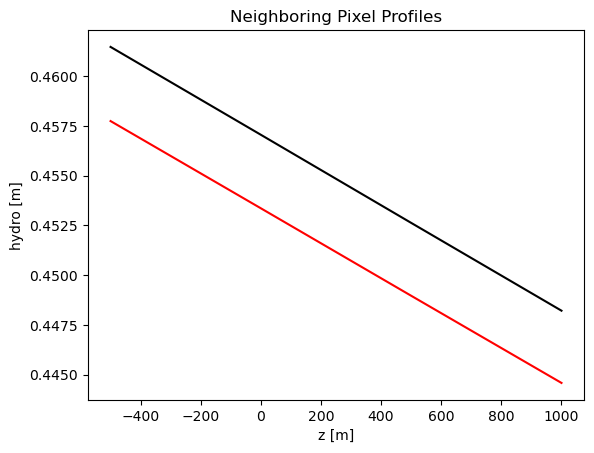

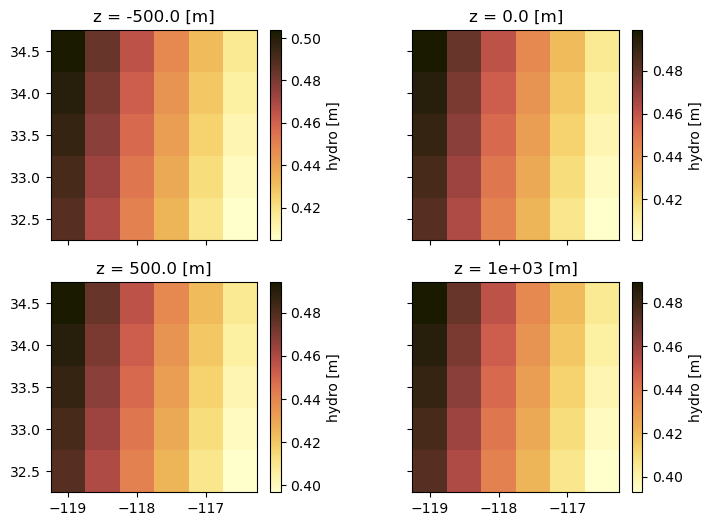

Min: 0.393
Any nan: False


In [15]:
## plot a profile of delays and the height levels

lalo_ix = (1,2) # random index of lat lon

fig, axes = plt.subplots()
da.isel(y=lalo_ix[0], x=lalo_ix[1]).plot(ax=axes, color='k')
da.isel(y=lalo_ix[0]+1, x=lalo_ix[1]).plot(ax=axes, color='red');
axes.set_title('Neighboring Pixel Profiles')

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(8,6))
for i, ax in enumerate(axes.ravel()):
    da.isel(z=i).plot(ax=ax, cmap='cmc.lajolla')#, vmin=0.058, vmax=0.061)
    ax.set_xlabel('')
    ax.set_ylabel('')
fig.subplots_adjust(wspace=0.4)
plt.show()

## ensure there are no nans/0s
print ('Min:', round(da.min().item(), 3))
print ('Any nan:', da.isnull().any().item())

In [16]:
## now build the rays at the unbuffered wm nodes , scaled by k1
targ_xyz = [da.x.data, da.y.data, da.z.data]
ray_data = build_ray_const(targ_xyz, Obj._zs, los, constant=const)

Mean delay over height level -500.0: 0.45103
Mean delay over height level 0.0: 0.44670
Mean delay over height level 500.0: 0.44236
Mean delay over height level 1000.0: 0.43804


In [17]:
## compare the delays in the cube vs the scaled rays

# in case of running in terminal
# da = xr.open_dataset(f'{wd}/{WM}_tropo_20200130T135245_ray.nc')['hydro']

raid_data = da.data
# print (np.allclose(ray_data[0], raid_data[0])) 

print (np.allclose(ray_data, raid_data)) 
da.close()
del da

True


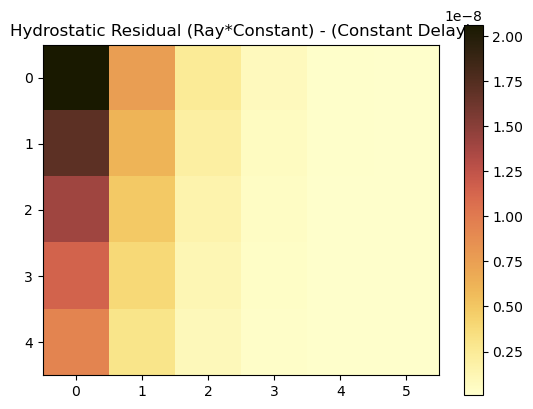

In [18]:
# plot the residual at one height level
hgt_lvl = 2
plt.imshow(ray_data[hgt_lvl] - raid_data[hgt_lvl], cmap='cmc.lajolla')
plt.title('Hydrostatic Residual (Ray*Constant) - (Constant Delay)')
plt.colorbar();

## Scenario 1b

- k1 = a number; 
- P=T; 
- k2=k3=0; 

LATERAL variation
integral would be k1*ray-length. 


# Test 2

Test the wet calculation
- k2'= a number; 
- k1=k3'=0; 

- then E=T or like E=1/100*T; 

- Integral would be k2'*1(or 1/100) * ray length. 

## Scenario 2a

No horizontal/vertical variation

In [22]:
!rm {wd}/weather_files/{WM}*

In [23]:
print ('S/N/W/E:', *SNWE)
print ('Grid Spacing:', cube_spacing, 'm')

S/N/W/E: 33 34 -118.25 -117.25
Grid Spacing: 50000.0 m


In [24]:
# remove the weather model file for a clean run
path_wm_real  = f'{op.splitext(path_wm)[0]}_REAL'

# use existing if possible
if op.exists(path_wm_real):
    os.remove(path_wm)
    os.symlink(path_wm, f'{op.splitext(path_wm)[0]}_REAL')
else:
    try:
        os.remove(f'{wd}/weather_files/{WM}_{dts}.nc')
    except:
        pass



## run it through with the real weather model file
grp = {
       'aoi_group': {'bounding_box': list(SNWE)},
        'height_group': {#'dem': 'GLO30_fullres_dem.tif', 
                         'height_levels': hgt_lvls.tolist(),
                        },
        'date_group': {'date_list': datetime.strftime(dt, '%Y%m%d')},
        'cube_spacing_in_m': str(cube_spacing),
        'los_group': {'ray_trace': True, 'orbit_file': orbit},
        'weather_model': WM
      }

cfg = new_yaml_group(yaml_GUNW, grp)
!raider.py {cfg}


if not op.exists(path_wm_real):
    os.rename(path_wm, path_wm_real)

Wrote new cfg file: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/tmp.yaml
Invalid extension GTiff for cube. Defaulting to .nc
Starting to run the weather model calculation
Date: 20200130
Beginning weather model pre-processing
Weather model GMAO is available from 2014-02-20 to Present
Number of weather model nodes: 24360
Shape of weather model: (12, 14, 145)
Bounds of the weather model: 32.00/34.75/-119.38/-115.31 (SNWE)
Weather model: GMAO
Mean value of the wet refractivity: 5.758169
Mean value of the hydrostatic refractivity: 105.635017

======Weather Model class object=====
Weather model time: 2020-01-30 13:52:45
Latitude resolution: 0.25
Longitude resolution: 0.3125
Native projection: EPSG:4326
ZMIN: -100.0
ZMAX: 15000.0
k1 = 0.776
k2 = 0.233
k3 = 3750.0
Humidity type = q
Class name: gmao
Dataset: gmao
A: []
B: []
Number of points in Lon/Lat = 12/14
Total number of grid points (3D): 24360

Output SNWE: [32.5, 34.5, -119.0, -116.5]
Output cube spacing: 0.5


In [25]:
## run it again with the synthetic model
const = 2.0
Obj   = GMAOsynth(wm_bounds, k1=0, k2=const, k3=0)

path_wm_synth = update_GMAO(Obj, path_wm_real)

os.remove(path_wm) if op.exists(path_wm) or op.islink(path_wm) else ''
os.symlink(path_wm_synth, path_wm)

!raider.py {cfg}

# get the just created synthetic delays
ds = xr.open_dataset(f'{wd}/{WM}_tropo_{dts.replace("_", "")}_ray.nc')
da = ds['wet']
ds.close()
del ds

## or just run tropo delay
# ds  = tropo_delay(dt, path_wm_synth, aoi, los, hgt_lvls, cube_spacing_m=cube_spacing)[0]
# da  = ds['wet']


Wrote synthetic weather model file to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/weather_files/GMAO_2020_01_30_T13_52_45_32N_35N_120W_115W_SYNTH.nc
Invalid extension GTiff for cube. Defaulting to .nc
Starting to run the weather model calculation
Date: 20200130
Beginning weather model pre-processing
Extent of the weather model is (xmin, ymin, xmax, ymax):-119.38, 32.00, -115.31, 34.75
Extent of the input is (xmin, ymin, xmax, ymax): -118.72, 32.53, -116.22, 34.47
Output SNWE: [32.5, 34.5, -119.0, -116.5]
Output cube spacing: 0.5
Processing slice 1 / 4: -500.0

Mean delay over height level -500.0: 0.12887
Processing slice 2 / 4: 0.0

Mean delay over height level 0.0: 0.12763
Processing slice 3 / 4: 500.0

Mean delay over height level 500.0: 0.12639
Processing slice 4 / 4: 1000.0

Mean delay over height level 1000.0: 0.12515

Successfully wrote delay cube to: /Users/buzzanga/Software_InSAR/RAiDER-docs_git/notebooks/Synthetic_Test/GMAO_tropo_20200130T135245_ra

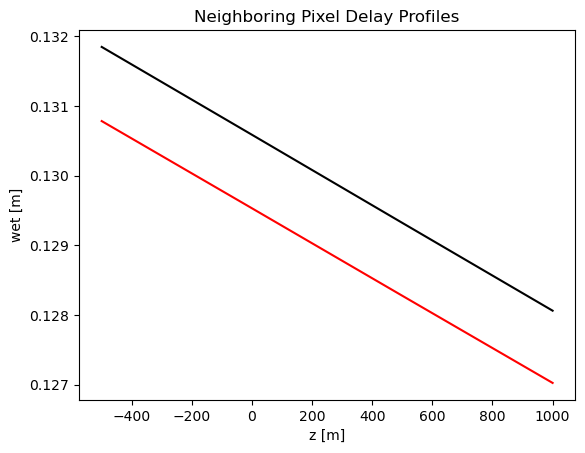

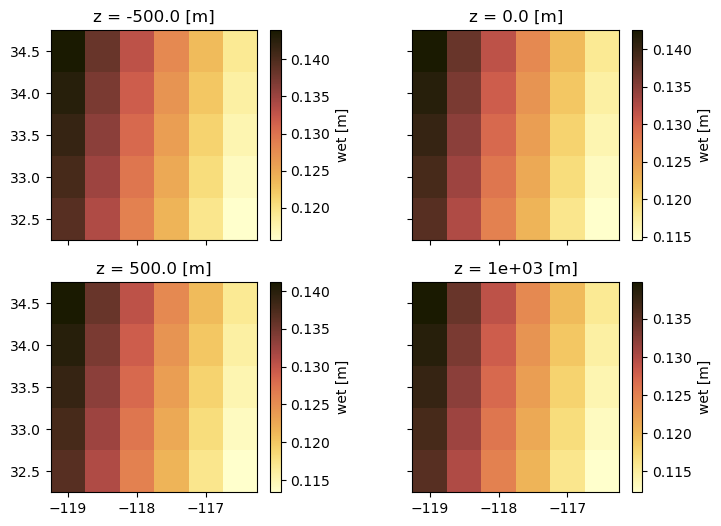

Min: 0.112
Any nan: False


In [26]:
## plot a profile of delays and the height levels

lalo_ix = (1,2) # random index of lat lon

fig, axes = plt.subplots()
da.isel(y=lalo_ix[0], x=lalo_ix[1]).plot(ax=axes, color='k')
da.isel(y=lalo_ix[0]+1, x=lalo_ix[1]).plot(ax=axes, color='red');
axes.set_title('Neighboring Pixel Delay Profiles')

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(8,6))
for i, ax in enumerate(axes.ravel()):
    da.isel(z=i).plot(ax=ax, cmap='cmc.lajolla')#, vmin=0.058, vmax=0.061)
    ax.set_xlabel('')
    ax.set_ylabel('')
fig.subplots_adjust(wspace=0.4)
plt.show()

## ensure there are no nans/0s
print ('Min:', round(da.min().item(), 3))
print ('Any nan:', da.isnull().any().item())

In [27]:
## now build the rays at the unbuffered wm nodes , scaled by k2
targ_xyz = [da.x.data, da.y.data, da.z.data]
ray_data = build_ray_const(targ_xyz, Obj._zs, los, constant=const)

Mean delay over height level -500.0: 0.12887
Mean delay over height level 0.0: 0.12763
Mean delay over height level 500.0: 0.12639
Mean delay over height level 1000.0: 0.12515


In [28]:
## compare the delays in the cube vs the scaled rays

# ds = xr.open_dataset(f'{wd}/{WM}_tropo_{dts.replace("_", "")}_ray.nc')['wet']
raider_data = da.data
print (np.allclose(ray_data, raider_data)) 
da.close()
del da 

True


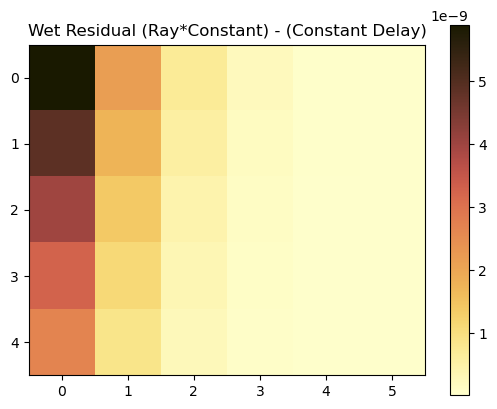

In [29]:
# plot the residual at one height level
hgt_lvl = 2
plt.imshow(ray_data[hgt_lvl] - raider_data[hgt_lvl], cmap='cmc.lajolla')
plt.title('Wet Residual (Ray*Constant) - (Constant Delay)')
plt.colorbar();

# Misc

## Estimate Projection Conversion Error

In [85]:
# this is only a fair comparison at the lowest height level
# you build the ray between two height levels. at the bottom of the height level, the unit 
def estimate_proj_error(xpts, ypts, low_ht, los:object):
    """ Estimate the error due to projecting back and forth at a certain height level
    
    Only compare at the single height, where the ray starts. As the ray builds it moves horiontally. 
    Lat/lons error is within nnumerical precision but height is off by about 1e-4
    """
    from pyproj import CRS, Transformer
    
    # Create a regular 2D grid
    xx, yy = np.meshgrid(xpts, ypts)

    llh = [xx, yy, np.full_like(yy, low_ht)]
    xyz = np.stack(lla2ecef(llh[1], llh[0], llh[2]), axis=-1)
    
    # Step 2 - get LOS vectors for targets (at the requested height level)
    LOS = los.getLookVectors(low_ht, llh, xyz, yy)

    ecef_to_model = Transformer.from_crs(CRS.from_epsg(4978), CRS.from_epsg(4326))
    low_xyz  = getTopOfAtmosphere(xyz, LOS, low_ht, factor=None)

    # ray point in ECEF
    ff = 0 # only care about the ray point on the ground, at the same x/y
    pts_xyz = low_xyz + ff #*(high_xyz - low_xyz)

    # Ray point in model coordinates
    pts = ecef_to_model.transform(
        pts_xyz[..., 0],
        pts_xyz[..., 1],
        pts_xyz[..., 2]
    )
    new_zs = pts[2] # the new z at each lat lon
    resid  = new_zs-low_ht
    return resid

In [87]:
resid_llh = estimate_proj_error(Obj._xs, Obj._ys, -500, los)*1000
print (f'(re)Projection induced error: {resid_llh.mean():.2f} +/- {resid_llh.std():.2f} mm')

(re)Projection induced error: -0.45 +/- 0.87 mm
